# **CS 5540 Group 6 Final Project Code Part 1, EDA and Replicating Other Work: By Danny Satterthwaite and Drew Jepsen**

#OVERVIEW

- link to outline: https://docs.google.com/document/d/1hP9R9FrTY0_MtSadcU9QGb8yvao2zngm/edit
- link to first draft: https://docs.google.com/document/d/1ikphtBtgL7INBx8lieIMRVVmmiJ0ZTQKwR4Gt7ZcWcI/edit?tab=t.0
- **[Link to Final Draft](https://docs.google.com/document/d/1ikphtBtgL7INBx8lieIMRVVmmiJ0ZTQKwR4Gt7ZcWcI/edit?usp=sharing)** PLACEHOLDER



In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier

In [ ]:
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CS5540/project/' # Drew
#GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CS5540/project/Shared with me/project/' #DANNY
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['data', 'cs5540 project']


In [ ]:
# Load the dataset
train_df = pd.read_csv(GOOGLE_DRIVE_PATH+'data/train.csv')
test_df = pd.read_csv(GOOGLE_DRIVE_PATH+'data/test.csv')
stores_df = pd.read_csv(GOOGLE_DRIVE_PATH+'data/stores.csv')
features_df = pd.read_csv(GOOGLE_DRIVE_PATH+'data/features.csv')


In [ ]:
print("Train Data:")
display(train_df.head())

print("\nTest Data:")
display(test_df.head())

print("\nStores Data:")
display(stores_df.head())

print("\nFeatures Data:")
display(features_df.head())

Train Data:


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False



Test Data:


,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False



Stores Data:


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875



Features Data:


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [ ]:
# Merge datasets to get all features in one dataframe
# NOTE TO SELF, DESPITE IT SAYING TRAIN, IT'S REALLY EVERYTHING, THIS IS JUST A NAMING LEFTOVER OF THE KAGGLE DATA
train_df = pd.merge(train_df, features_df, on=['Store', 'Date', 'IsHoliday'], how='left')
train_df = pd.merge(train_df, stores_df, on=['Store'], how='left')

# Handle missing values in MarkDown columns
# Fill missing markdowns with 0
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
train_df[markdown_cols] = train_df[markdown_cols].fillna(0)

# Handle missing values in other columns
train_df['CPI'].fillna(train_df['CPI'].mean(), inplace=True)
train_df['Unemployment'].fillna(train_df['Unemployment'].mean(), inplace=True)

# Feature engineering
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df['Year'] = train_df['Date'].dt.year
train_df['Month'] = train_df['Date'].dt.month
train_df['Week'] = train_df['Date'].dt.isocalendar().week

# Encode categorical variables
train_df['IsHoliday'] = train_df['IsHoliday'].astype(int)  # Converts True/False to 1/0

# One-hot encoding for Store Type (from stores.csv)
train_df = pd.get_dummies(train_df, columns=['Type'], drop_first=True)

# Feature Scaling
scaler = StandardScaler()
numerical_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales'] + markdown_cols
train_df[numerical_cols] = scaler.fit_transform(train_df[numerical_cols])

# Display the preprocessed dataframe
train_df.head()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  int64         
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     421570 non-null  float64       
 8   MarkDown2     421570 non-null  float64       
 9   MarkDown3     421570 non-null  float64       
 10  MarkDown4     421570 non-null  float64       
 11  MarkDown5     421570 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Size          421570 non-null  int64         
 15  Year          421

### Get the counts of holidays (Informs our decision for classification scoring metric)
- 29661 holidays, 391909 not holidays = 29661/(29661+391909) =7%. Thus clearly our dataset is inbalanced so we don't want to us just strait up accuracy
-Is it better to use precision or recall? --> precision is perfered when we dont want to say a week is a holiday week when in fact it is not. Ie, if we say its a holiday week, it must be a holiday week. So the bar is high so some weeks that are holday weeks don't get tagged (mistakes) as holiday weeks.
- Recall would be to cast a wide net so we make sure we get all the instances of holidays weeks knowing we may tag a few weeks that arent holiday weeks as holiday weeks
- So what do we want:
- https://scikit-learn.org/dev/modules/model_evaluation.html#scoring-parameter


In [ ]:
counts_holiday = train_df['IsHoliday'].value_counts()
display(counts_holiday)

In [ ]:
def weighted_mean_absolute_error(y_true, y_pred, is_holiday):
    # Set weights: 5 for holiday weeks, 1 for non-holiday weeks
    # Holidays are 5 based on the dataset description stating holidays are 5 times more important
    weights = np.where(is_holiday == 1, 5, 1)

    errors = np.abs(y_true - y_pred)
    wmae = np.sum(weights * errors) / np.sum(weights)

    return wmae

#Phase 1 Models
- Initial goal is to predict sales (Y) using everything but date (X). We will expand upon this later.
- Note to self, of course we don't include week as "week" may effectivly uniquely correspond to a sales total.

In [ ]:
# Defining X and Y
X = train_df.drop(['Weekly_Sales', 'Date'], axis=1)
y = train_df['Weekly_Sales']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


## Phase 1 Linear Reg

In [ ]:
# Linear Model Predictor

# Initialize the Linear Regression model
lr_model = LinearRegression()

# Fit the model on the training data
lr_model.fit(X_train, y_train)

# Predict on the validation data
y_pred_lr = lr_model.predict(X_val)

# Calculate mean absolute error (MAE)
mae = mean_absolute_error(y_val, y_pred_lr)
print(f"Mean Absolute Error: {mae:.4f}")

# Calculate Weighted Mean Absolute Error (WMAE) using the holiday flag
is_holiday = X_val['IsHoliday']  # Assuming 'IsHoliday' exists in features
wmae = weighted_mean_absolute_error(y_val, y_pred_lr, is_holiday)
print(f"Weighted Mean Absolute Error (WMAE): {wmae:.4f}")


Mean Absolute Error: 0.6412
Weighted Mean Absolute Error (WMAE): 0.6533


##Phase 1 Random Forests

In [ ]:
#Random Forest Regressor Model

rf_model = RandomForestRegressor(n_estimators=130, random_state=42, n_jobs=-1,max_depth=30, max_features=6)

# Fit the mode
rf_model.fit(X_train, y_train)

# Predict on the validation data
y_pred_rf = rf_model.predict(X_val)

# Calculate mean absolute error (MAE)
mae = mean_absolute_error(y_val, y_pred_rf)
print(f"Mean Absolute Error: {mae:.4f}")

# Calculate Weighted Mean Absolute Error (WMAE) using the holiday flag
is_holiday = X_val['IsHoliday']  # Assuming 'IsHoliday' exists in features
wmae = weighted_mean_absolute_error(y_val, y_pred_rf, is_holiday)
print(f"Weighted Mean Absolute Error (WMAE): {wmae:.4f}")


Mean Absolute Error: 0.1751
Weighted Mean Absolute Error (WMAE): 0.1958


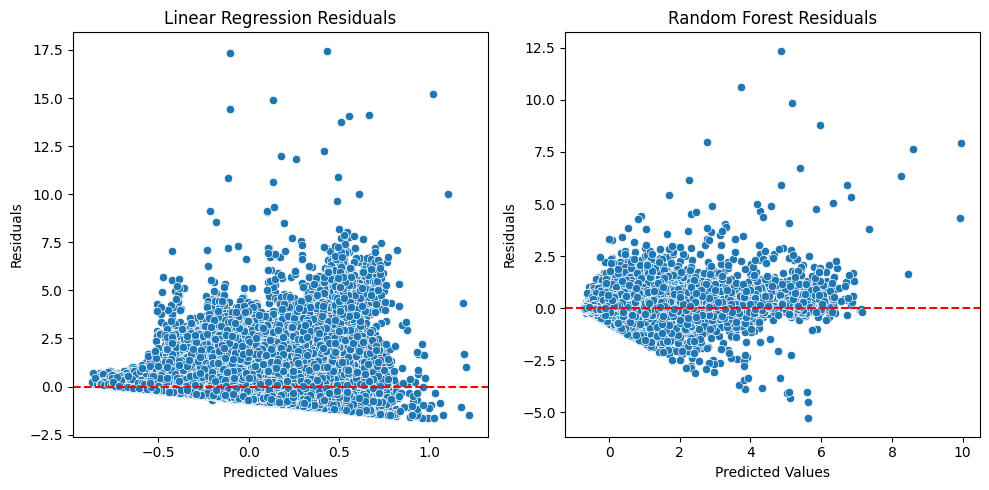

In [ ]:
# Residuals for Linear Regression
residuals_lr = y_val - y_pred_lr

# Residuals for Random Forest
residuals_rf = y_val - y_pred_rf

# Plot Residuals for Linear Regression
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred_lr, y=residuals_lr)
plt.axhline(0, color='r', linestyle='--')
plt.title('Linear Regression Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Plot Residuals for Random Forest
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred_rf, y=residuals_rf)
plt.axhline(0, color='r', linestyle='--')
plt.title('Random Forest Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()


##PCA Tweaking of the above models

In [ ]:
#Perform PCA before conducting models
n = 10 # number of components

# Scale the features
X_scaled = scaler.fit_transform(X)

# Step 2: Apply PCA
pca = PCA(n_components=n)
X_pca = pca.fit_transform(X_scaled)

# Step 3: Split data into training and validation sets
X_train_pca, X_val_pca, y_train, y_val = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Step 4: Linear Regression on PCA-transformed data
# Initialize the Linear Regression model
lr_model = LinearRegression()

# Fit the model on PCA-transformed training data
lr_model.fit(X_train_pca, y_train)

# Predict on the PCA-transformed validation data
y_pred_lr = lr_model.predict(X_val_pca)

# Calculate mean absolute error for Linear Regression
mae_lr = mean_absolute_error(y_val, y_pred_lr)
print(f"Linear Regression MAE (with PCA): {mae_lr:.4f}")

# Calculate WMAE for Linear Regression
is_holiday = X_val_pca[:, -1]  # Assuming 'IsHoliday' was retained as a feature in PCA
wmae_lr = weighted_mean_absolute_error(y_val, y_pred_lr, is_holiday)
print(f"Linear Regression WMAE (with PCA): {wmae_lr:.4f}")

# Step 5: Random Forest Regressor on PCA-transformed data
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=130, random_state=42, n_jobs=-1,max_depth=30, max_features=6)

# Fit the model on PCA-transformed training data
rf_model.fit(X_train_pca, y_train)

# Predict on the PCA-transformed validation data
y_pred_rf = rf_model.predict(X_val_pca)

# Calculate mean absolute error for Random Forest
mae_rf = mean_absolute_error(y_val, y_pred_rf)
print(f"Random Forest MAE (with PCA): {mae_rf:.4f}")

# Calculate WMAE for Random Forest
wmae_rf = weighted_mean_absolute_error(y_val, y_pred_rf, is_holiday)
print(f"Random Forest WMAE (with PCA): {wmae_rf:.4f}")

Linear Regression MAE (with PCA): 0.6438
Linear Regression WMAE (with PCA): 0.6438
Random Forest MAE (with PCA): 0.2740
Random Forest WMAE (with PCA): 0.2740


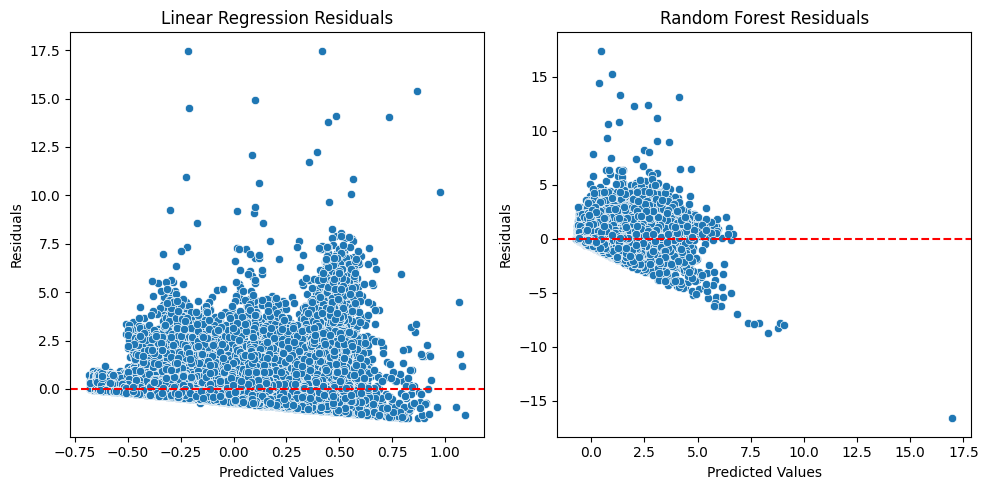

In [ ]:
# Residuals for Linear Regression
residuals_lr = y_val - y_pred_lr

# Residuals for Random Forest
residuals_rf = y_val - y_pred_rf

# Plot Residuals for Linear Regression
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred_lr, y=residuals_lr)
plt.axhline(0, color='r', linestyle='--')
plt.title('Linear Regression Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Plot Residuals for Random Forest
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred_rf, y=residuals_rf)
plt.axhline(0, color='r', linestyle='--')
plt.title('Random Forest Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()


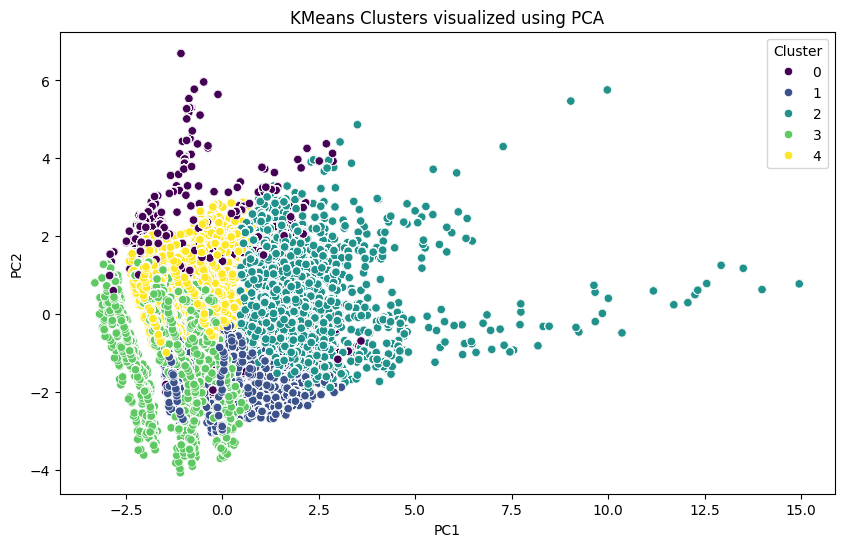

In [ ]:
#Kmeans into PCA to viz
X = train_df.drop(['Weekly_Sales', 'Date'], axis=1)

# Step 1: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_scaled)
train_df['Cluster'] = kmeans.labels_
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = kmeans.labels_

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis')
plt.title('KMeans Clusters visualized using PCA')
plt.show()


#Phase 2 --> The 'Actual' Models  See next file here: https://drive.google.com/file/d/1_OfDqMUOM3tO25gnCefm8KKhqwJewd1J/view?usp=sharing